# Triangles (single regular polygon)

We define some scripts to create the cutting patterns for one of the 3 regular tesselations.<br>
In particular for the triangle

### Strategy

- We define a basic shape made of a triangle using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [1]:
# Imports
import math

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

### Canvas and Polygon sizes

In [ ]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 177
tabica_width = 906

INSET_RATIO = 0.9

triangle_radius = 21.2 

### Polygon creation

In [3]:
def create_regular_polygon(center_x, center_y, radius, nr_points):
    angle = 2 * math.pi / nr_points
    polygon_points = []

    for i in range(nr_points):
        x = center_x + radius * math.cos(i * angle)
        y = center_y + radius * math.sin(i * angle)
        polygon_points.append((x, y))

    return Polygon(polygon_points)

# Create a triangle (3 sides)
triangle = create_regular_polygon(0,0,triangle_radius, 3)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [4]:
# translate_x = 0   # Translate 50mm on the X axis
# translate_y = triangle_radius/2 + hexagon_radius*math.cos(math.pi/6)   # Translate 50mm on the Y axis

triangle_up = affinity.rotate(triangle, 90, origin="centroid")
triangle_down = affinity.rotate(triangle, -90, origin="centroid")

polygon_dict = {}
polygon_dict['T0'] = triangle_up
polygon_dict['T1'] = affinity.translate(triangle_up, 
                                 +2*triangle_radius*math.sin(math.pi/3),
                                 0)
 
polygon_dict['T2'] = affinity.translate(triangle_down, 
                                 +triangle_radius*math.sin(math.pi/3),
                                 +triangle_radius*math.cos(math.pi/3))

polygon_dict['T3'] = affinity.translate(triangle_down,
                                +3*triangle_radius*math.sin(math.pi/3),
                                +triangle_radius*math.cos(math.pi/3))

polygon_dict['T4'] = affinity.translate(triangle_up, 
                                        +triangle_radius*math.sin(math.pi/3),
                                       +3*triangle_radius*math.cos(math.pi/3))    
        

In [5]:
polygon_dict = {}
polygon_dict['T0'] = triangle_up
polygon_dict['T2'] = affinity.translate(triangle_down, 
                                 +triangle_radius*math.sin(math.pi/3),
                                 +triangle_radius*math.cos(math.pi/3))

### Plotting Dictionaries of Shapes

In [6]:
def plot_polygon_dict(polygons, colors=None, alphas=None):
    """
    Function to plot a dictionary of polygons
    :param polygons: dictionary of polygons to plot
           note that keys are used as labels
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(polygons)))
    if alphas is None:
        alphas = [0.1] * len(polygons)

    # for polygon, color, alpha in zip(polygons, colors, alphas):
    color_idx = 0
    for key, polygon in polygons.items():
        x, y = polygon.exterior.xy
        ctr = centroid(polygon)
        ax.plot(x, y, color=colors[color_idx])
        # ax.fill(x, y, alpha=alpha, color="white")
        ax.text(ctr.x, ctr.y, key, fontsize=12, ha='center', va='center')
        color_idx += 1

    ax.axis('equal')

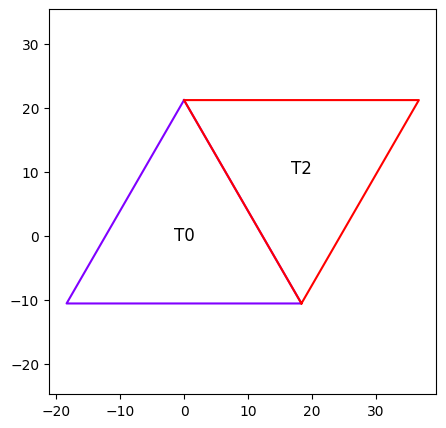

In [7]:
plot_polygon_dict(polygon_dict)

### Translations
The collection of polygons above can be translated to fill the plane as shown below:

In [8]:
# Define the translation
up_1_x = triangle_radius*math.sin(math.pi/3) 
up_1_y = 3*triangle_radius*math.cos(math.pi/3)

right_x = 2*triangle_radius*math.sin(math.pi/3)
right_y = 0

# Translate all polygons
translated_polygons = {
    f"{key}-t": affinity.translate(poly, right_x*2, right_y*2) for key, poly in polygon_dict.items()
}

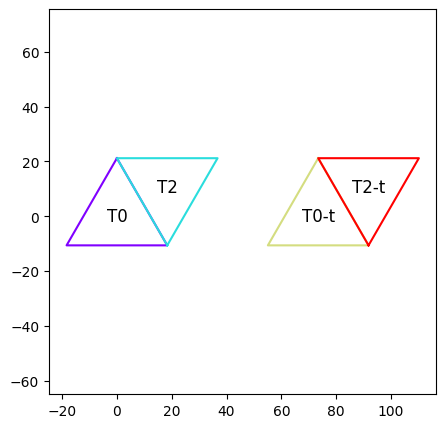

In [9]:
super_polys = {**polygon_dict, **translated_polygons}
plot_polygon_dict(super_polys)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [10]:
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define 2 translations
- **up_t:** For *up* triangles
- **down_t:** For *down* triangles 


In [11]:
# Translate all polygons
def translate_polygon_up(polygon_list, nr_translations): 
    """ 
    takes a triangle and applies the up-triangle
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    
    # Define the basic UP + RIGHT translation
    x_up = triangle_radius*math.sin(math.pi/3) 
    y_up = 3*triangle_radius*math.cos(math.pi/3) 
    
    up_polygons = [
    affinity.translate(poly, x_up * nr_translations, y_up * nr_translations) for poly in polygon_list
    ]
    return up_polygons

def translate_polygon_right(polygon_list, nr_translations):
    """
    takes a list of polygons and applies the to the right
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    # Define the basic RIGHT translation
    right_x = 2*triangle_radius*math.sin(math.pi/3)*nr_translations
    right_y = 0
    
    right_polygons = [
    affinity.translate(poly, right_x, right_y) for poly in polygon_list
    ]
    return right_polygons


### Plotting Lists of Polygons

In [12]:
def plot_polygon_list(polygons, colors=None, alphas=None):
    fig, ax = plt.subplots(figsize=(5, 5))

    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(polygons)))
    if alphas is None:
        alphas = [0.1] * len(polygons)

    for polygon, color, alpha in zip(polygons, colors, alphas):
        x, y = polygon.exterior.xy
        ax.plot(x, y, color=color)

    ax.axis('equal')
    plt.show()

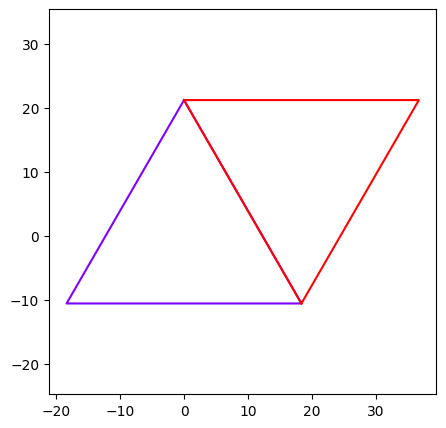

In [13]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

1. We create a "basic polygon group" made of 2 triangles
   * This column is created by translating the last copied group to the right and up
   * We repeat this process until we have a big enough column (about 8 or 9 copies)

 2. We return to the base of the column, and translate one "basic polygon group" to the right

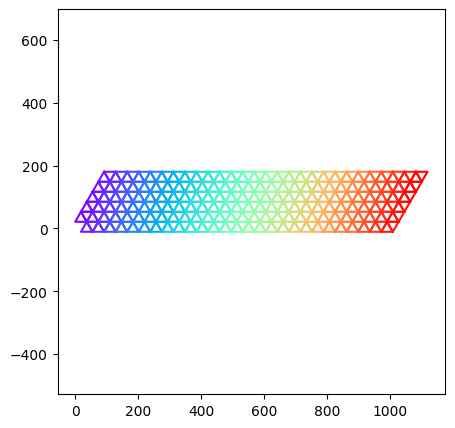

In [14]:
initial_polygon_list = list(polygon_dict.values())
full_polygon_list = []

index_right = 28
index_up = 6

# First create the initial column
for k in range(1, index_up):
    tmp_poly_group = translate_polygon_up(initial_polygon_list, k)
    full_polygon_list += tmp_poly_group

# Now translate the initial set right to create new columns
for k in range(1, index_right):
    # Translate the initial set right
    right_translated = translate_polygon_right(initial_polygon_list, k)
    # Add this translated set to the full list
    full_polygon_list += right_translated
    # Create the column above this translated set
    for j in range(1, index_up):
        up_translated = translate_polygon_up(right_translated, j)
        full_polygon_list += up_translated


plot_polygon_list(full_polygon_list)        

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [15]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [16]:
def center_rectangle_on_polygons(polygons, rectangle):
    # Calculate the bounding box of all polygons
    all_polygons = Polygon()
    for poly in polygons:
        all_polygons = all_polygons.union(poly)

    polygons_bbox = all_polygons.bounds

    # Calculate centroids
    polygons_centroid = box(*polygons_bbox).centroid
    rectangle_centroid = rectangle.centroid

    # Calculate the translation needed
    dx = polygons_centroid.x - rectangle_centroid.x
    dy = polygons_centroid.y - rectangle_centroid.y

    # Apply translation to the rectangle
    centered_rectangle = affinity.translate(rectangle, dx, dy)

    return centered_rectangle

# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

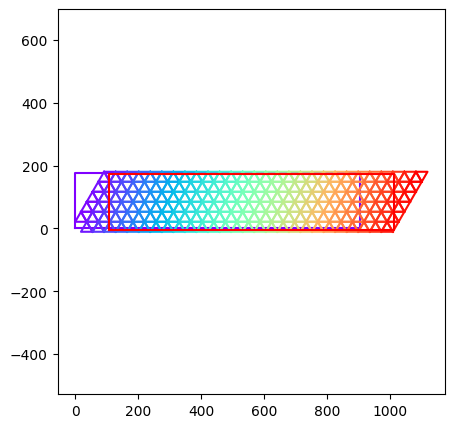

In [17]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

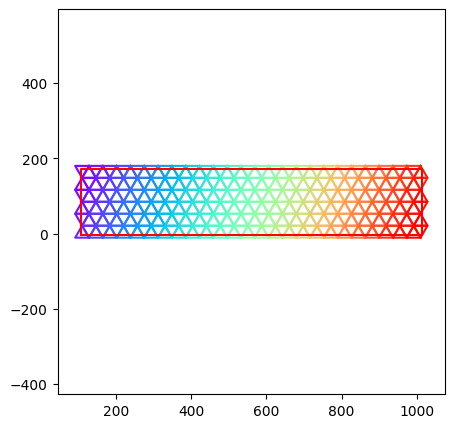

In [18]:
def is_polygon_inside_frame(polygon, rect):
    """Check if the centroid of a polygon is inside a rectangle."""
    x, y = polygon.centroid.x, polygon.centroid.y
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [19]:
INSET_DISTANCE = 3.6   # X ratio gives gaps of about 2Xmm
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



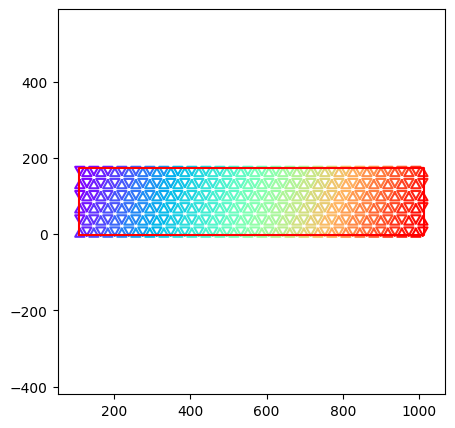

In [20]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

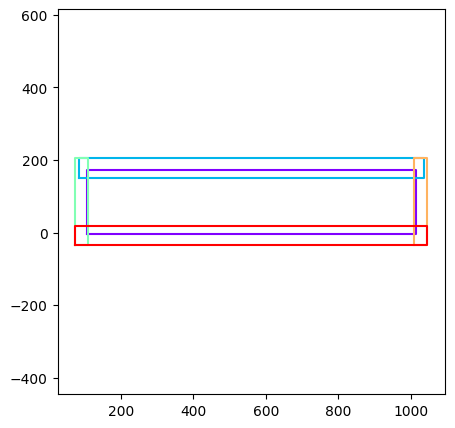

In [21]:
band_width = 22
side_inset = 18
top_band = polygons([[centered_frame.bounds[0] - band_width, centered_frame.bounds[3] - band_width],
                    [centered_frame.bounds[0] - band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] - band_width]])

left_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[1] - band_width - 10]])

right_band = polygons([[centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

bottom_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                        [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [22]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [23]:
top_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
left_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
right_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
bottom_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]

# deduplicate the list of polygons overlapped by each band:
band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
# keep the polygons outside of bands for later:
all_other_polygons = [polygon for polygon in inset_polygon_list if polygon not in band_polygons]

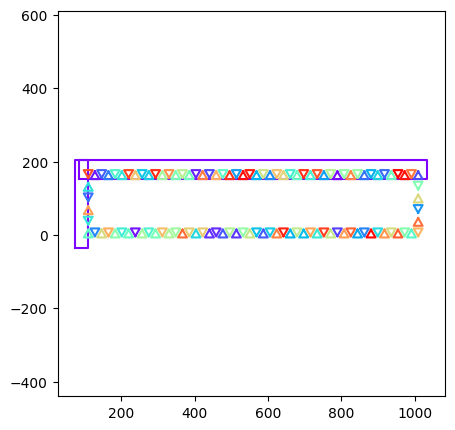

In [24]:
plot_polygon_list([top_band] + [left_band] + band_polygons)

In [25]:
cropped_polygons = []
for poly in band_polygons:
    bit_to_keep_t = poly.difference(top_band)
    bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
    bit_to_keep_l = bit_to_keep_b.difference(left_band)
    bit_to_keep = bit_to_keep_l.difference(right_band)
    cropped_polygons.append(bit_to_keep)


# some polygons are cropped down to nothing (no coordinates), so we need to remove them
cropped_polygons = [poly for poly in cropped_polygons if poly.exterior] 

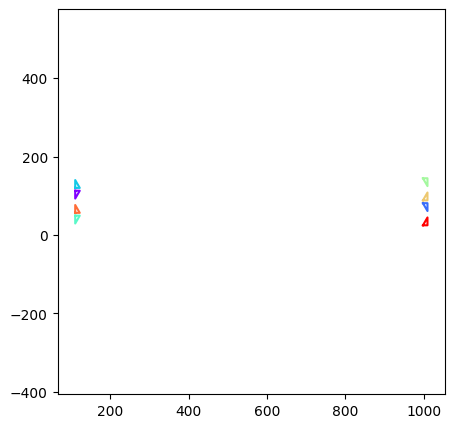

In [26]:
plot_polygon_list(cropped_polygons)

In [27]:
final_polygons =  all_other_polygons + cropped_polygons + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [28]:
len(final_polygons)

201

In [29]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_polygons.remove(poly)
    

In [30]:
len(final_polygons)

201

### Save POLYGONS to SVG

In [31]:
def save_polygon_list_to_svg(polygon_list, filename='tramo1.2.svg', size=('1200mm', '300mm')):
    # Create a new SVG drawing with 1mm = 1 user unit scale
    dwg = svgwrite.Drawing(filename, size=size, profile='full', viewBox=f"0 0 {size[0].replace('mm','')} {size[1].replace('mm','')}")
    
    #---------------------------------------
    # Find bounding box of all polygons
    all_coords = []
    for polygon in polygon_list:
        all_coords.extend(polygon.exterior.coords)
    min_x = min(x for x,y in all_coords)
    max_x = max(x for x,y in all_coords)
    min_y = min(y for x,y in all_coords)
    max_y = max(y for x,y in all_coords)
    
    # Calculate center offset to move polygons to canvas center
    poly_width = max_x - min_x
    poly_height = max_y - min_y
    canvas_width = float(size[0].replace('mm',''))
    canvas_height = float(size[1].replace('mm',''))
    
    x_offset = (canvas_width - poly_width)/2 - min_x
    y_offset = (canvas_height - poly_height)/2 # - min_y
    
    
    # Create a group for all paths & add transform to center the group
    group = dwg.g(fill='none', stroke='blue', 
                  stroke_width=0.5, 
                  transform=f'translate({x_offset},{y_offset})')

    # Calculate the maximum y-coordinate to use for flipping
    max_y = max(max(coord[1] for coord in polygon.exterior.coords) for polygon in polygon_list)
    
    # Iterate through the polygons in the list
    for polygon in polygon_list:
        # Extract coordinates from the Shapely polygon, flip the y-coordinate
        coords = [(coord[0], max_y - coord[1]) for coord in polygon.exterior.coords]

        # Create a path
        path = dwg.path(d=f'M {coords[0][0]},{coords[0][1]}')

        # Add line segments to the path
        for coord in coords[1:]:
            path.push(f'L {coord[0]},{coord[1]}')

        # Close the path
        path.push('Z')

        # Add the path to the group
        group.add(path)

    # Add the group to the drawing
    dwg.add(group)

    # Save the drawing
    dwg.save()

# Usage
# Assuming polygon_list is your list of Shapely polygons
save_polygon_list_to_svg(full_polygon_list + [centered_frame])


# SAVE


In [32]:
save_polygon_list_to_svg(final_polygons, filename='tramo1.2.svg')